In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
rootDir_I = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
resultDir_I = rootDir_I + '05_result/'
logDir_I = rootDir_I + '06_log/'

In [3]:
rootDir_II = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
resultDir_II = rootDir_II + '05_result/'
logDir_II = rootDir_II + '06_log/'

In [4]:
rootDir_tot = 'L:/DATA/Alouette_I/Total/'
resultDir_tot = rootDir_tot + '05_result/'
logDir_tot = rootDir_tot + '06_log/'

In [5]:
def analyze_batch(filename, batch_name, category_type, total_df):
    df = pd.read_csv (filename)
    total = len(df)
    print (f'Number of Images Analyzed in {batch_name}: {total}')
    
    #Batch Summary
    df_filter = df.loc[df['Issue']!= 'None']
    filtered_down = len (df_filter)
    print (f' Number of Ionograms categorized correctly consistently in {batch_name}, {category_type}: {total - filtered_down}')
    
    #Suucess Rate:
    success_rate = (total - filtered_down)/total
    Estimation = round (success_rate * total_df)
    print (f' Estimated success rate out of {batch_name} with {total_df} ionogram: {Estimation}')
    
    #Number of all categories error
    df_all_categories = df.loc [df['Issue'] == 'All category']
    filtered_down_all_categories = len (df_all_categories)
    print (f'Number of incorrectly analyzed ionogram across all categories in {batch_name}, {category_type}: {filtered_down_all_categories}')
    print (df_all_categories.loc[:, ['Directory', 'Subdirectory', 'filename']])
    
    print ('Element Analysis:')
    
    categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
    accuracy_data = []
    confidence_level = 0.95
    z_score = 1.96 #norm.ppf(1-(1-confidence_level)/2)
    
    for column in categorical_columns:
        col_sum = df[column].sum()
        p = col_sum / total
        accuracy_percent = p*100
        sample_error = np.sqrt(p*(1-p)/total)*100
        confidence_interval = z_score*sample_error
        
        print(f'Number of "{column}" element categorized correctly:' , col_sum)
        print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
        print (f'Sample Error for "{column}" element: {sample_error:.2f}')
        print (f'Confidence Interval for the "{column}" element: {confidence_interval:.2f}')
        
        accuracy_data.append ((column, accuracy_percent,sample_error, confidence_interval))
        
   
    #plotting
    fig = plt.figure(figsize = (10, 5))
    categories, accuracies,sample_error, confidence_interval  = zip(*accuracy_data) 
    bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
    lower_error = np.zeros_like(sample_error)
    error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
    plt.ylim(70, 107)

    plt.title (f"% Reading accuracy of the {category_type} metadata elements in {batch_name}", fontweight = 'bold')
    plt.xlabel(f"{category_type} metadata elements - {batch_name}", fontweight = 'bold')
    plt.ylabel(f"Reading Accuracy (%)", fontweight = 'bold')
    plt.xticks(rotation=90)
    plt.yticks (np.arange(70, 107, step = 10))
    #creating a legend
    legend_handles = [bar[0], error_bar]
    legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
    plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

    #adding numbers on top of the error bars and bars
    for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
        text_height = max(bar_height, bar_height+err_height)
        if text_height >100:
            text_height = 100
        plus_minus = '\u00B1' # used for +- symbol
        err_text = f'{plus_minus}{conf_interval:.2f}'
        plt.text(i, bar_height + err_height+ 4.5 ,f'{bar_height:.2f}\n{err_text}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.subplots_adjust(bottom = 0.25, top = 1.7, left = 0.1, right= 0.95)
    plt.show()

## Num Category

In [6]:
#Total Number of Num Categories
df_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_I = df_I[df_I['processed_image_class']=='num']
total_df_I = len(filter_df_I)
print ('Total number of NUM Ionograms in Batch I:', total_df_I)

df_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_II = df_II[df_II['processed_image_class']=='num']
total_df_II = len(filter_df_II)
print ('Total number of NUM Ionograms in Batch II :', total_df_II)

Total_num = total_df_I + total_df_II #combining Batch I and Batch II num data
print ('Total number of NUM Ionograms in both batches:', Total_num)

Total number of NUM Ionograms in Batch I: 465009
Total number of NUM Ionograms in Batch II : 114045
Total number of NUM Ionograms in both batches: 579054


### Batch I

Number of Images Analyzed in Batch_I: 49
 Number of Ionograms categorized correctly consistently in Batch_I, NUM: 45
 Estimated success rate out of Batch_I with 465009 ionogram: 427049
Number of incorrectly analyzed ionogram across all categories in Batch_I, NUM: 1
     Directory Subdirectory       filename
3  R014207909F          713  Image0317.png
Element Analysis:
Number of "year" element categorized correctly: 48
Percent reading accuracy of the "year" element: 97.96%
Sample Error for "year" element: 2.02
Confidence Interval for the "year" element: 3.96
Number of "Day_1" element categorized correctly: 48
Percent reading accuracy of the "Day_1" element: 97.96%
Sample Error for "Day_1" element: 2.02
Confidence Interval for the "Day_1" element: 3.96
Number of "Day_2" element categorized correctly: 48
Percent reading accuracy of the "Day_2" element: 97.96%
Sample Error for "Day_2" element: 2.02
Confidence Interval for the "Day_2" element: 3.96
Number of "Day_3" element categorized corre

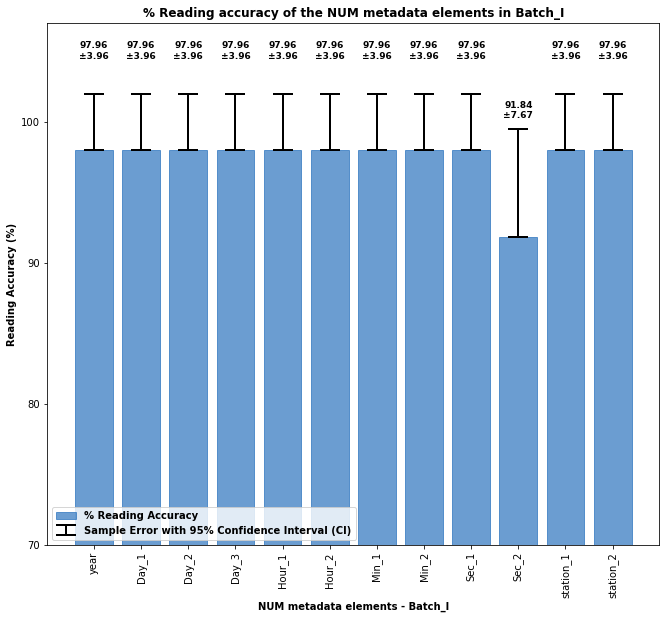

In [7]:
analyze_batch ("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_QA.csv", 'Batch_I', 'NUM', total_df_I)

### Batch II

Number of Images Analyzed in Batch_2: 50
 Number of Ionograms categorized correctly consistently in Batch_2, NUM: 45
 Estimated success rate out of Batch_2 with 114045 ionogram: 102640
Number of incorrectly analyzed ionogram across all categories in Batch_2, NUM: 4
     Directory Subdirectory filename
11  R014207820      2979-5B  109.png
16  R014207825     3729-19A  105.png
44  R014207808      4575-50   14.png
49  R014207819      4757-15   77.png
Element Analysis:
Number of "year" element categorized correctly: 45
Percent reading accuracy of the "year" element: 90.00%
Sample Error for "year" element: 4.24
Confidence Interval for the "year" element: 8.32
Number of "Day_1" element categorized correctly: 46
Percent reading accuracy of the "Day_1" element: 92.00%
Sample Error for "Day_1" element: 3.84
Confidence Interval for the "Day_1" element: 7.52
Number of "Day_2" element categorized correctly: 46
Percent reading accuracy of the "Day_2" element: 92.00%
Sample Error for "Day_2" element:

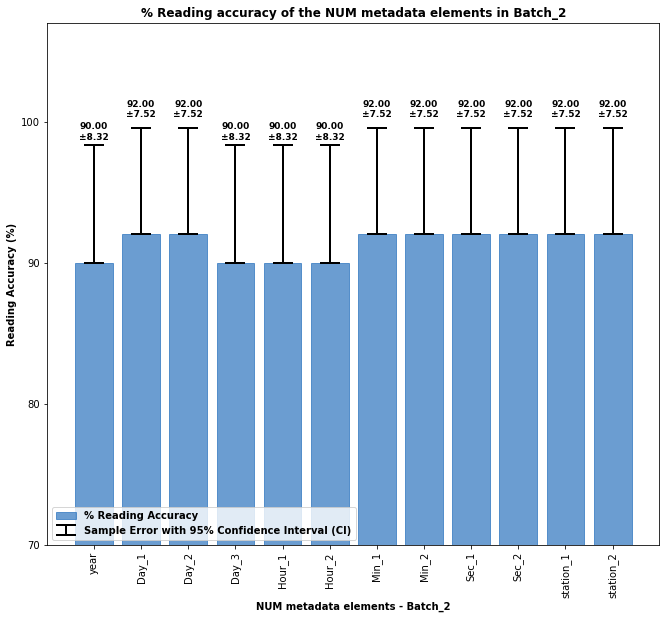

In [8]:
analyze_batch ("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num.csv", 'Batch_2', 'NUM', total_df_II)

### Total NUM category analysis

In [ ]:
sample_size = total_I + total_II
print(sample_size)

combined_accuracy_data = []
for i in range(len(categorical_columns)):
    column = categorical_columns [i]
    #combined_accuracy = ((accuracy_data_I[i][1] + accuracy_data_II[i][1])/2)/100 #YOU CAN'T TAKE AN AVERAGE IN THIS WAY UNLESS BATCH I and BATCH II SAMPLE ARE THE SAME SIZE
    combined accuracy = (n_BATCH_I_images_correct + n_BATCH_II_images_correct)/(n_BATCH_I_sample + n_BATCH_II_sample)
    #combined_sample_error = np.sqrt((accuracy_data_I[i][2]**2 + accuracy_data_II[i][2]**2)/2) #YOU CAN'T TAKE AN AVERAGE OF SQUARE ROOTS. USE THE EQUATION!
    combined_sample_error = np.sqrt(combined_accuracy*(1-combined_accuracy)/sample_size)
    #print(combined_sample_error)
    combined_confidence_interval = z_score*combined_sample_error
    combined_accuracy_data.append((column, combined_accuracy,combined_sample_error,  combined_confidence_interval))
    
#plotting the graph of batch I and II
fig = plt.figure(figsize = (10, 5))
categories, accuracies,sample_error, confidence_interval  = zip(*combined_accuracy_data) 
bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
lower_error = np.zeros_like(sample_error)
error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
plt.ylim(70, 105)
plt.title ("% Reading accuracy of the overall NUM metadata elements", fontweight = 'bold')
plt.xlabel("NUM metadata elements",  fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)",  fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks(np.arange(70, 105, step = 10))

#adding a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plus_minus = '\u00B1' # used for +- symbol
    err_text = f'{plus_minus}{conf_interval:.2f}'
    plt.text(i, bar_height + err_height+ 4 ,f'{bar_height:.2f}\n{err_text}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.subplots_adjust(bottom = 0.25, top = 1.7, left = 0.1, right= 0.95)
plt.show()
                                                                  

## NUM2 category

In [ ]:
#Total Number of Num Categories
df_num2_1 = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_num2_1 = df_num2_1[df_num2_1['processed_image_class']=='num2']
total_df_num2_1 = len(filter_df_num2_1)
print ('Total number of NUM2 Ionograms in Batch I:', total_df_num2_1)

df_num2_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_num2_II = df_num2_II[df_num2_II['processed_image_class']=='num2']
total_df_num2_II = len(filter_df_num2_II)
print ('Total number of NUM2 Ionograms in Batch II :', total_df_num2_II)

df_num2_total = pd.read_csv(resultDir_tot + 'result_master.csv')
filter_df_total= df_num2_total[df_num2_total['processed_image_class']=='num2']
total_df_num2 = len(filter_df_total)
print('Total number of NUM2 Ionograms in both batches:', total_df_num2)

### Batch I

In [ ]:
df_num2_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_num2_QA.csv") 
total_num2_I = len(df_num2_I)
print ('Number of Images Analyzed in BATCH I:', total_num2_I)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_num2_I = []
confidence_level = 0.95
z_score = norm.ppf(1-(1-confidence_level)/2)
for column in categorical_columns:
    col_sum = df_num2_I[column].sum()
    p = col_sum/total_num2_I
    accuracy_percent = p*100
    sample_error = np.sqrt(p*(1-p)/total_num2_I)*100
    confidence_interval = z_score + sample_error
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    print (f'Confidence Interval for the "{column}" element: {confidence_interval:.2f}')
    
    accuracy_data_num2_I.append((column, accuracy_percent,sample_error, confidence_interval))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies,sample_error, confidence_interval  = zip(*accuracy_data_num2_I) 
bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
lower_error = np.zeros_like(sample_error)
error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
plt.ylim(70, 105)

plt.title ("% Reading accuracy of the NUM2 metadata elements in Batch I", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements - Batch I", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks (np.arange(70, 105, step = 10))

#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding the labels
for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plus_minus = '\u00B1' # used for +- symbol
    err_text = f'{plus_minus}{conf_interval:.2f}'
    plt.text(i, bar_height + err_height+ 2.5 ,f'{bar_height:.2f}\n{err_text}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.subplots_adjust(bottom = 0.25, top = 1.7, left = 0.1, right= 0.95)
plt.show()

In [ ]:
# BATCH I - Summary
df_num2_I  = df_num2_I.loc[df_num2_I ['Issue'] != 'None']
filtered_down_num2_I = len(df_num2_I)
print ('Batch I Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_num2_I - filtered_down_num2_I)

#BATCH II - Estimated success rate
success_rate = (total_num2_I - filtered_down_num2_I)/total_num2_I
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of BATCH II with 126,073 ionograms:', Estimation)
# Number of All categories error
df_num2_I = df_num2_I.loc[df_num2_I['Issue'] == 'Day']
filtered_down_I = len(df_num2_I)
print('The algorithm reads Day_2 and Day_3 inccorectly with no clear pattern:', filtered_down_I)
print(df_num2_I.loc[:,["Directory","Subdirectory", "filename"]])

###  Batch II

In [ ]:
df_num2_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num2.csv") 
total_num2_II = len(df_num2_II)
print ('Number of Images Analyzed in BATCH II:', total_num2_II)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_num2_II = []
confidence_level = 0.95
z_score = norm.ppf(1-(1-confidence_level)/2)
for column in categorical_columns:
    col_sum = df_num2_II[column].sum()
    p = col_sum/total_num2_II
    accuracy_percent = p*100
    sample_error = np.sqrt(p*(1-p)/total_num2_II)*100
    confidence_interval = z_score + sample_error
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    print (f'Confidence Interval for the "{column}" element: {confidence_interval:.2f}')
    
    accuracy_data_num2_II.append((column, accuracy_percent,sample_error, confidence_interval))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies,sample_error, confidence_interval  = zip(*accuracy_data_num2_II) 
bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
lower_error = np.zeros_like(sample_error)
error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
plt.ylim(70, 105)

plt.title ("% Reading accuracy of the NUM2 metadata elements in Batch II", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements - Batch II", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks (np.arange(70, 105, step = 10))
#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding the labels
for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plus_minus = '\u00B1' # used for +- symbol
    err_text = f'{plus_minus}{conf_interval:.2f}'
    plt.text(i, bar_height + err_height+ 2.5 ,f'{bar_height:.2f}\n{err_text}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.subplots_adjust(bottom = 0.25, top = 1.7 , left = 0.1, right= 0.95)
plt.show()


In [ ]:
#BatchII - summary
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '07_MQA/'

#Total Number of Num2 Categories
df_master = pd.read_csv(resultDir + 'Original_data.csv')
filter_df_num2 = df_master[df_master['processed_image_class']=='num2']
total_df_master = len(filter_df_num2)
print ('Total number of NUM2 scanned Ionograms:', total_df_master)

#Total number of Ionograms analyzed
df_num2 = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num2.csv")
total_len = len(df_num2)
print ('Number of Images Analyzed:', total_len)

# filtering out correct categories
df_num2 = df_num2.loc[df_num2['Issue'] != 'None']
filtered_down_len = len(df_num2)
print('Number of Ionograms categorized correctly:', total_len - filtered_down_len)

#Estimated success rate
success_rate = (total_len - filtered_down_len)/total_len
Estimation = round(success_rate*total_df_master)
print('Estimated Success Rate out of 87924 NUM2 data with consistent results:', Estimation)

# Number of Minute error
df_num2 = df_num2.loc[df_num2['Issue'] == 'Minute']
filtered_down_len = len(df_num2)
print('Number of NUM2 "Minutes" categorized inccorectly:', filtered_down_len)
print('Algorithm read 1 and 7 or 1 and 9 interchangbly.')
print(df_num2.loc[:,["Directory","Subdirectory", "filename"]])

### Total NUM2 Category

In [ ]:
combined_accuracy_data_num2 = []
for i in range(len(categorical_columns)):
    column = categorical_columns [i]
    combined_accuracy =(accuracy_data_num2_I[i][1] + accuracy_data_num2_II[i][1])/2
    combined_sample_error = np.sqrt((accuracy_data_num2_I[i][2]**2 + accuracy_data_num2_II[i][2]**2)/2)
    combined_confidence_interval = z_score * combined_sample_error
    
    combined_accuracy_data_num2.append((column, combined_accuracy,combined_sample_error,  combined_confidence_interval))
    
    
#plotting the graph of batch I and II
fig = plt.figure (figsize= (10, 5))
categories, accuracies, sample_error, confidence_interval = zip(*combined_accuracy_data_num2)
bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
lower_error = np.zeros_like(sample_error)
error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)

plt.ylim(70, 106)
plt.title ("% Reading accuracy of the overall NUM2 metadata elements", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements",  fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)",  fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks(np.arange(70, 105, step = 10))

#adding a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plus_minus = '\u00B1' # used for +- symbol
    err_text = f'{plus_minus}{conf_interval:.2f}'
    plt.text(i, bar_height + err_height+ 6.3, f'{bar_height:.2f}\n{err_text}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.subplots_adjust(bottom = 0.25, top = 1.7 , left = 0.1, right= 0.95)
plt.show()

             

## Dot category

In [ ]:
df_dot_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_dot_I = df_dot_I[df_dot_I['processed_image_class']=='dot']
total_df_dot_I= len(filter_df_dot_I)
print ('Total number of dot Ionograms in BATCH I:', total_df_dot_I)

df_dot_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_dot_II = df_dot_II[df_dot_II['processed_image_class']=='dot']
total_df_dot_II = len(filter_df_dot_II)
print ('Total number of dot Ionograms in BATCH II:', total_df_dot_II)

Total_dot = total_df_dot_I + total_df_dot_II  #combining Batch I and Batch II num data
print ('Total dot ionograms in Batch I and II: ', Total_dot)

In [ ]:
#Batch I
df_dot_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_dot_QA.csv")
total_dot_I = len(df_dot_I)
print('Number of dot Ionograms Analyzed:', total_dot_I)

# filtering out correct categories
df_dot_I= df_dot_I.loc[df_dot_I['Issue'] != 'None']
filtered_down_dot_I = len(df_dot_I)
print('Number of ionograms categorized correctly:', total_dot_I - filtered_down_dot_I)

#Estimated success rate
success_rate = (total_dot_I - filtered_down_dot_I)/total_dot_I
Estimation = round(success_rate*total_df_dot_I)
print('Estimated Success Rate out of 7784 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_I = df_dot_I["Issue"].value_counts()
plt.bar(issue_counts_dot_I.index, issue_counts_dot_I.values)
plt.title ("Variation error of Batch I dot ionograms")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# Number of All categories error
df_dot_I = df_dot_I.loc[df_dot_I['Issue'] == 'All categories']
print(df_dot_I.loc[:,["Directory","Subdirectory", "Filename"]])


In [ ]:
#Batch II
df_dot_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_dot.csv")
total_dot_II = len(df_dot_II)
print ('Number of Images Analyzed:', total_dot_II)
filtered_down_dot_II = 0 #no ionogram was analyzed correctly
print('Number of Ionograms Analyzed correctly:',filtered_down_dot_II)

#Estimated success rate
success_rate = filtered_down_dot_II/total_dot_II
Estimation = success_rate*total_df_dot_II
print('Estimated Success Rate out of 4481 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_II = df_dot_II["Issue"].value_counts()
plt.bar(issue_counts_dot_II.index, issue_counts_dot_II.values)
plt.title ("Variation error of dot Ionograms in Batch II")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# filtering out correct categories
df_dot_II = df_dot_II.loc[df_dot_II['Issue'] == 'All categories']
filtered_down_dot_II = len(df_dot_II)
print('Number of NUM/NUM2 ionograms categorized as dot data by the algorithm:', filtered_down_dot_II)
print(df_dot_II.loc[:,["Directory","Subdirectory", "filename"]])

In [ ]:
#Total Dot image analysis:
Image_total_dot = total_dot_I + total_dot_II
print ('Total number of DOT Ionograms in BATCH I and II analyzed:', Image_total_dot)

Correct_total_dot = (total_dot_I - filtered_down_dot_I) + (total_dot_II - filtered_down_dot_II)
print ('Total number of Dot Ionograms in BATCH II and II analyzed correctly: ', Correct_total_dot)

#Estimated success rate
Estimation  = round(Correct_total_dot*Image_total_dot/Total_dot)
print('Estimated Success Rate of Total Dot with 12,265 ionograms:', Estimation)

#Percent certaintly
percent_tot_dot = Estimation*100/Total_dot
print('Estimated Percent certainty:' , percent_tot_dot)

## Overall summary across all categories

In [ ]:
data = [
    {
        'Category': 'num',
        'Image_processed': 579054,
        'Image_manually_read': 99,
        'Estimated_correct_read': 529689,#estimation out of total num data
        '%Image_read_correctly':94,
        'p': 0,

    },
    
    {
        'Category': 'dot',
        'Image_processed':12265,
        'Image_manually_read': 25,
        'Estimated_correct_read': 0, #estimation out of total dot data
        '%Image_read_correctly':0,
    },
    {
      'Category': 'num2',
        'Image_processed':126073,
        'Image_manually_read': 70,
        'Estimated_correct_read': 105061, #estimation out of total num2 data
        '%Image_read_correctly':90 ,
    }
    
]

confidence_interval = 0.95
z_score = 1.96 #norm.ppf(1-(1-confidence_interval)/2)

for category in data: 
    image_processed = category['Image_processed']
    images_manually_read = category ['Image_manually_read']
    estimated_correct_read = category ['Estimated_correct_read']
    percent_accuracy =  category ['%Image_read_correctly']
    p = estimated_correct_read/image_processed
    sample_error = np.sqrt(p*(1-p)/image_processed)*100
    confidence_interval = z_score + sample_error
    
    category['Sample_error'] = sample_error
    category['Confidence_interval'] = confidence_interval
    
for category in data: 
    print(f"Category:{category['Category']}")
    print(f"Images Processed:{category['Image_processed']}")
    print(f"Images manually read:{category['Image_manually_read']}")
    print(f"Estimated correct reading out of total ionograms in the category:{category['Estimated_correct_read']}")
    print(f"Percent of images read correctly:{category['%Image_read_correctly']:.2f}")
    print(f"Sample Error:{category['Sample_error']:.2f}")
    print(f"Confidence Interval:{category['Confidence_interval']:.2f}\n")
    
    
    
    